## Feature Store

In [3]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
from time import gmtime, strftime
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
import time
from botocore.exceptions import ClientError
from sklearn.preprocessing import StandardScaler

boto_session = boto3.Session()
sagemaker_client = boto_session.client(service_name='sagemaker')
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime')

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

# set up S3 bucket
default_bucket = feature_store_session.default_bucket()
prefix = "predictive-maintenance-feature-store"

# load the data
s3_client = boto3.client('s3')
response = s3_client.get_object(Bucket=default_bucket, Key='root/aai-540-homework/homework-2-1/data/dataset.csv')
df = pd.read_csv(response['Body'])

print("Dataset loaded successfully. Shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Dataset loaded successfully. Shape: (124494, 12)

First few rows of the dataset:
       date    device  failure    metric1  metric2  metric3  metric4  metric5  \
0  1/1/2015  S1F01085        0  215630672       55        0       52        6   
1  1/1/2015  S1F0166B        0   61370680        0        3        0        6   
2  1/1/2015  S1F01E6Y        0  173295968        0        0        0       12   
3  1/1/2015  S1F01JE0        0   79694024        0        0        0        6   
4  1/1/2015  S1F01R2B        0  135970480        0        0        0       15   

   metric6  metric7  metric8  metric9  
0   407438        0        0        7  
1   403174        0        0        0  
2   237394        0        0        0  
3   410186        0        0        0  
4   313173        0        0       

In [4]:
print(f'The total number of failures is: {df["failure"].sum()}')


The total number of failures is: 106


## EDA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# basic info
print(df.info())
print(df.describe())

# missing values
print("\nMissing values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB
None
             failure       metric1        metric2        metric3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223881e+08     159.492706       9.940897   
std         0.029167  7.045933e+07    2179.677781     185.748131   
min         0.000000  0.0000

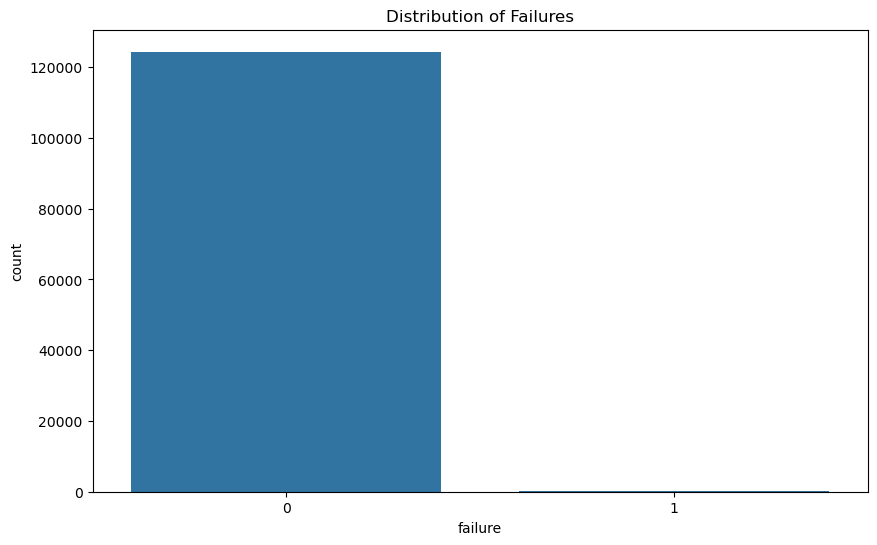

In [6]:
# Plot distribution of the target variable (failure)
plt.figure(figsize=(10, 6))
sns.countplot(x='failure', data=df)
plt.title('Distribution of Failures')
plt.show()

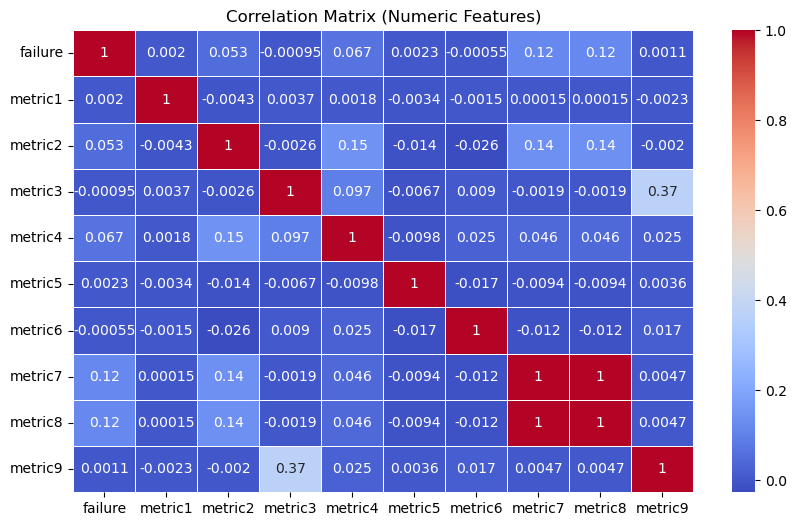

In [7]:
# Select only numeric columns for correlation matrix
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

# Plot correlation matrix for numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

### Failure Rate by device

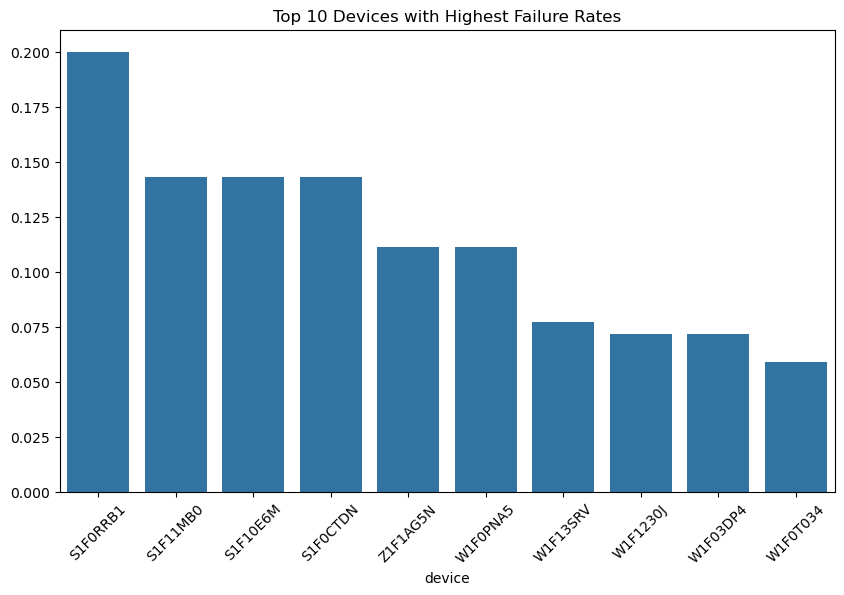

In [8]:
device_failure_rate = df.groupby('device')['failure'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=device_failure_rate.index[:10], y=device_failure_rate.values[:10])
plt.title('Top 10 Devices with Highest Failure Rates')
plt.xticks(rotation=45)
plt.show()

### Failures over time

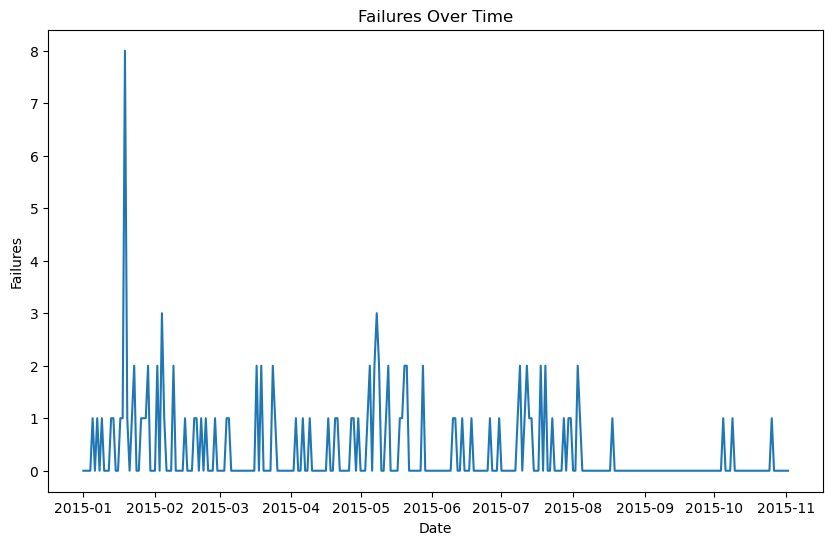

In [9]:
# Time series analysis for failures
df['date'] = pd.to_datetime(df['date'])
failures_over_time = df.groupby('date')['failure'].sum()
plt.figure(figsize=(10, 6))
plt.plot(failures_over_time.index, failures_over_time.values)
plt.title('Failures Over Time')
plt.xlabel('Date')
plt.ylabel('Failures')
plt.show()

### Failure vs Device Usage

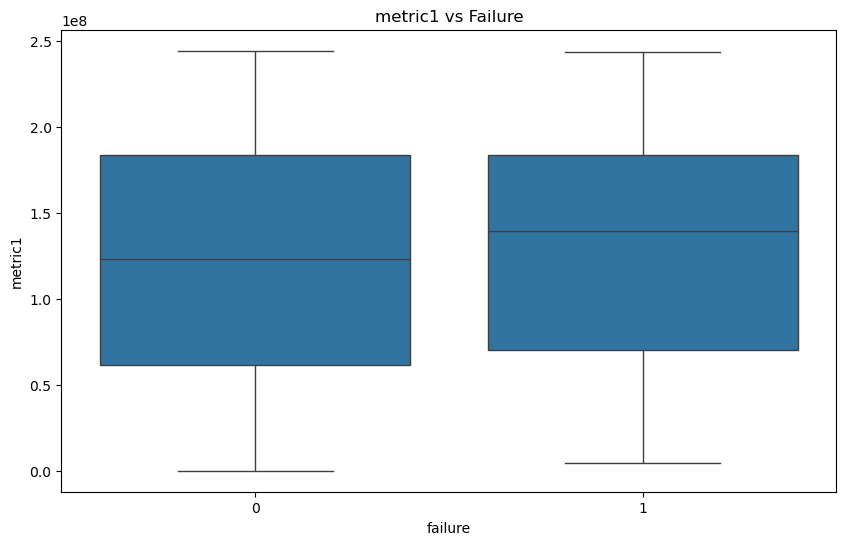

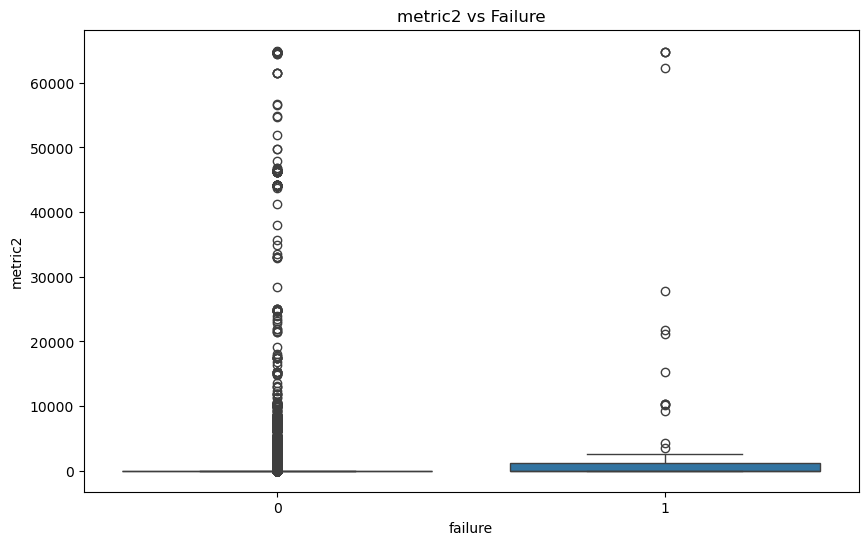

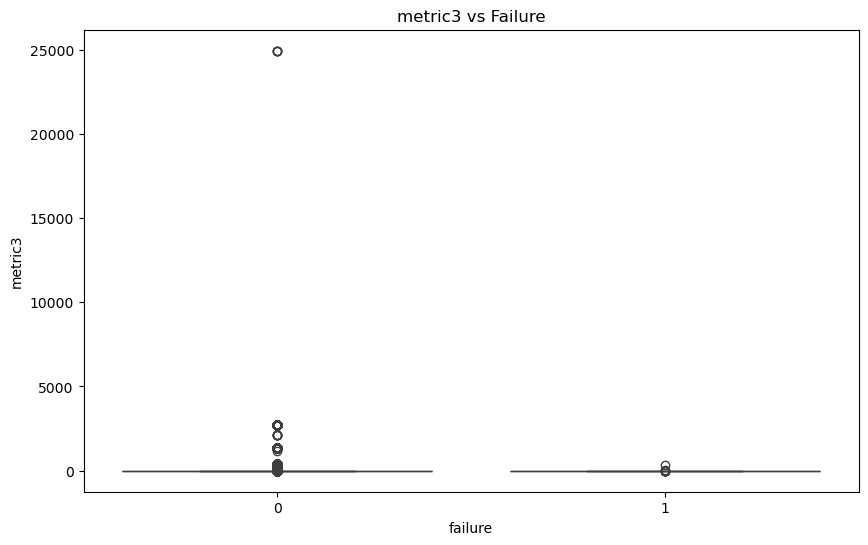

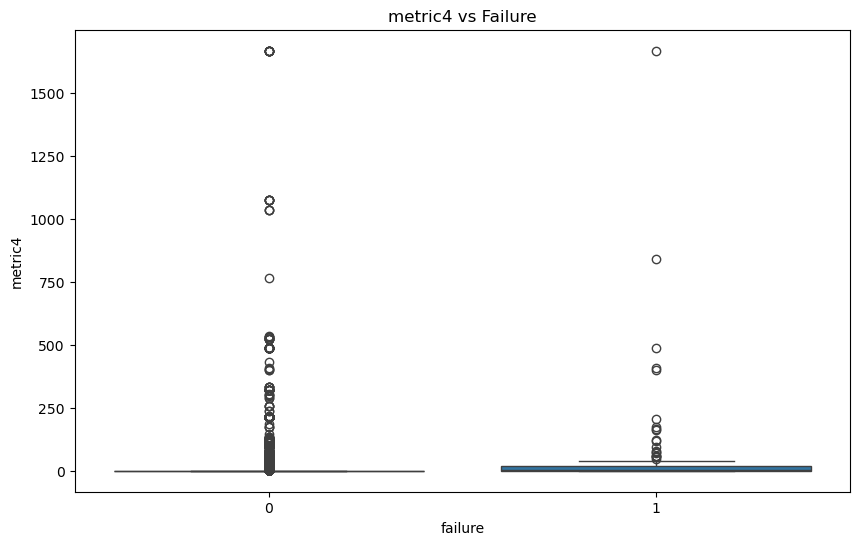

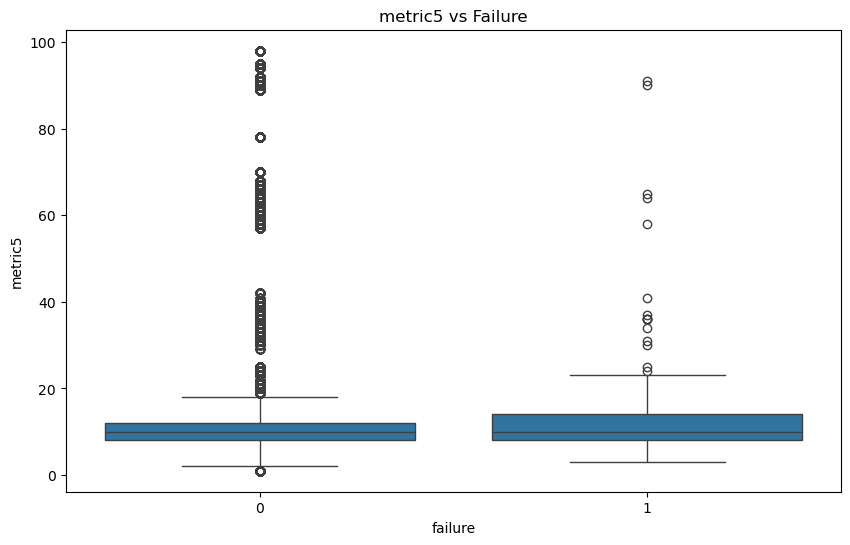

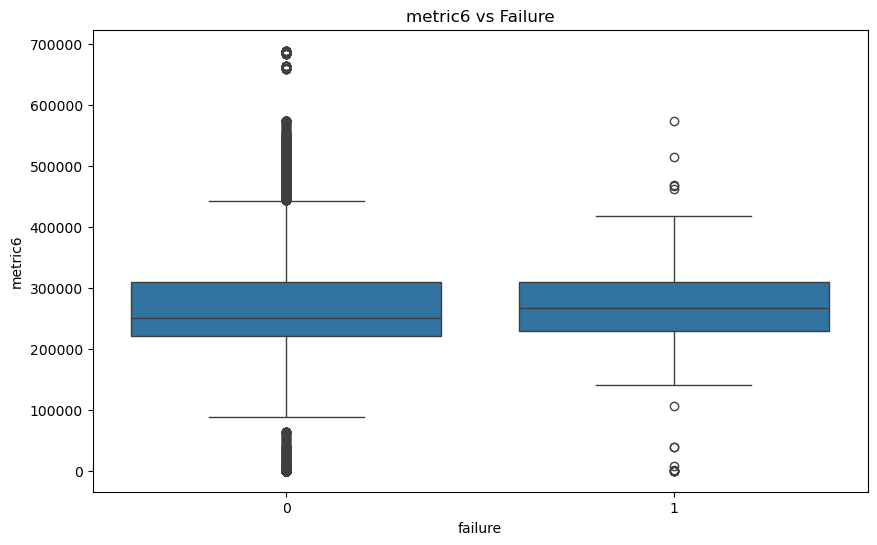

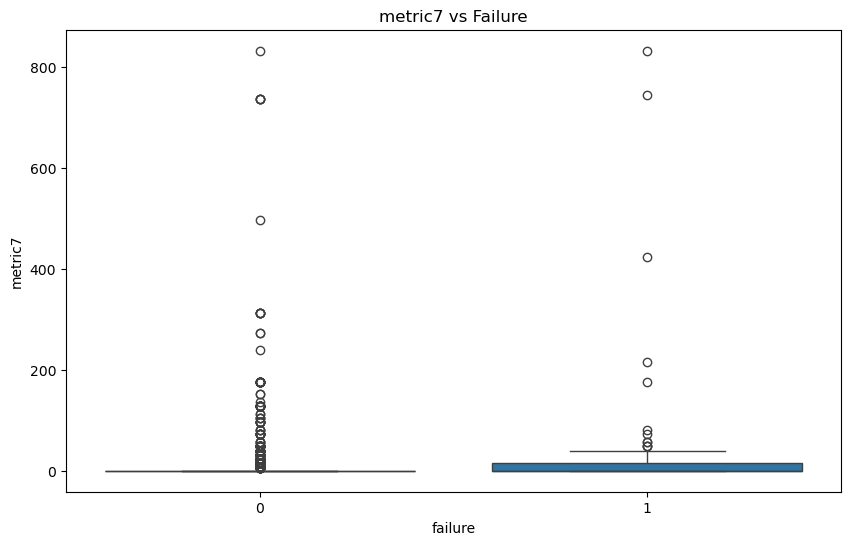

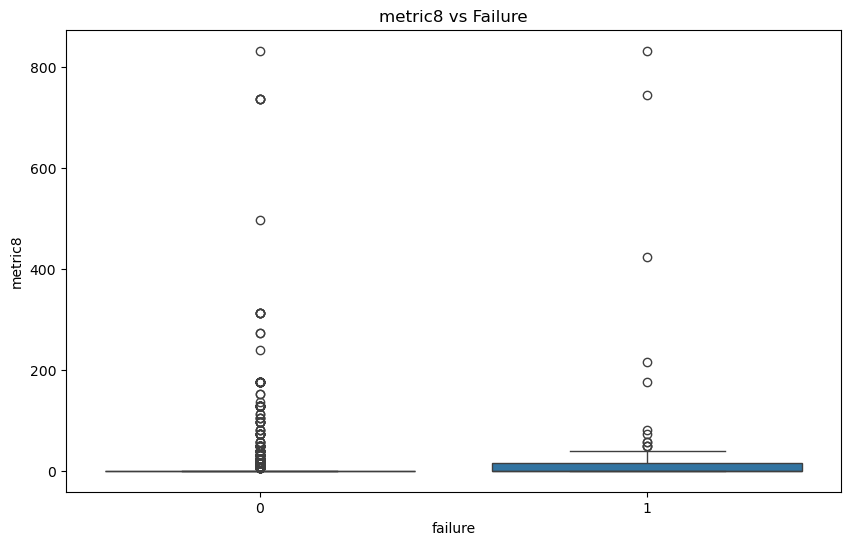

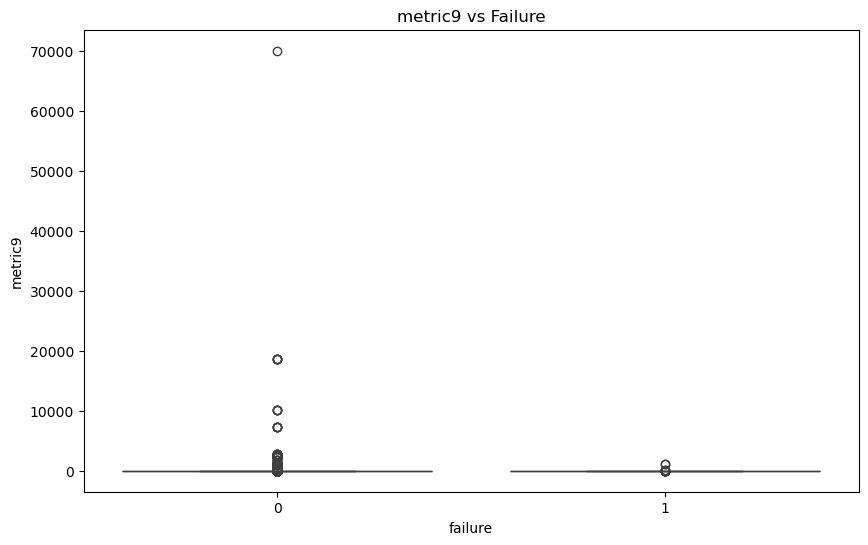

In [10]:
# List of all metric columns
metric_columns = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']

# Loop through each metric and plot boxplot against failure
for metric in metric_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='failure', y=metric, data=df)
    plt.title(f'{metric} vs Failure')
    plt.show()

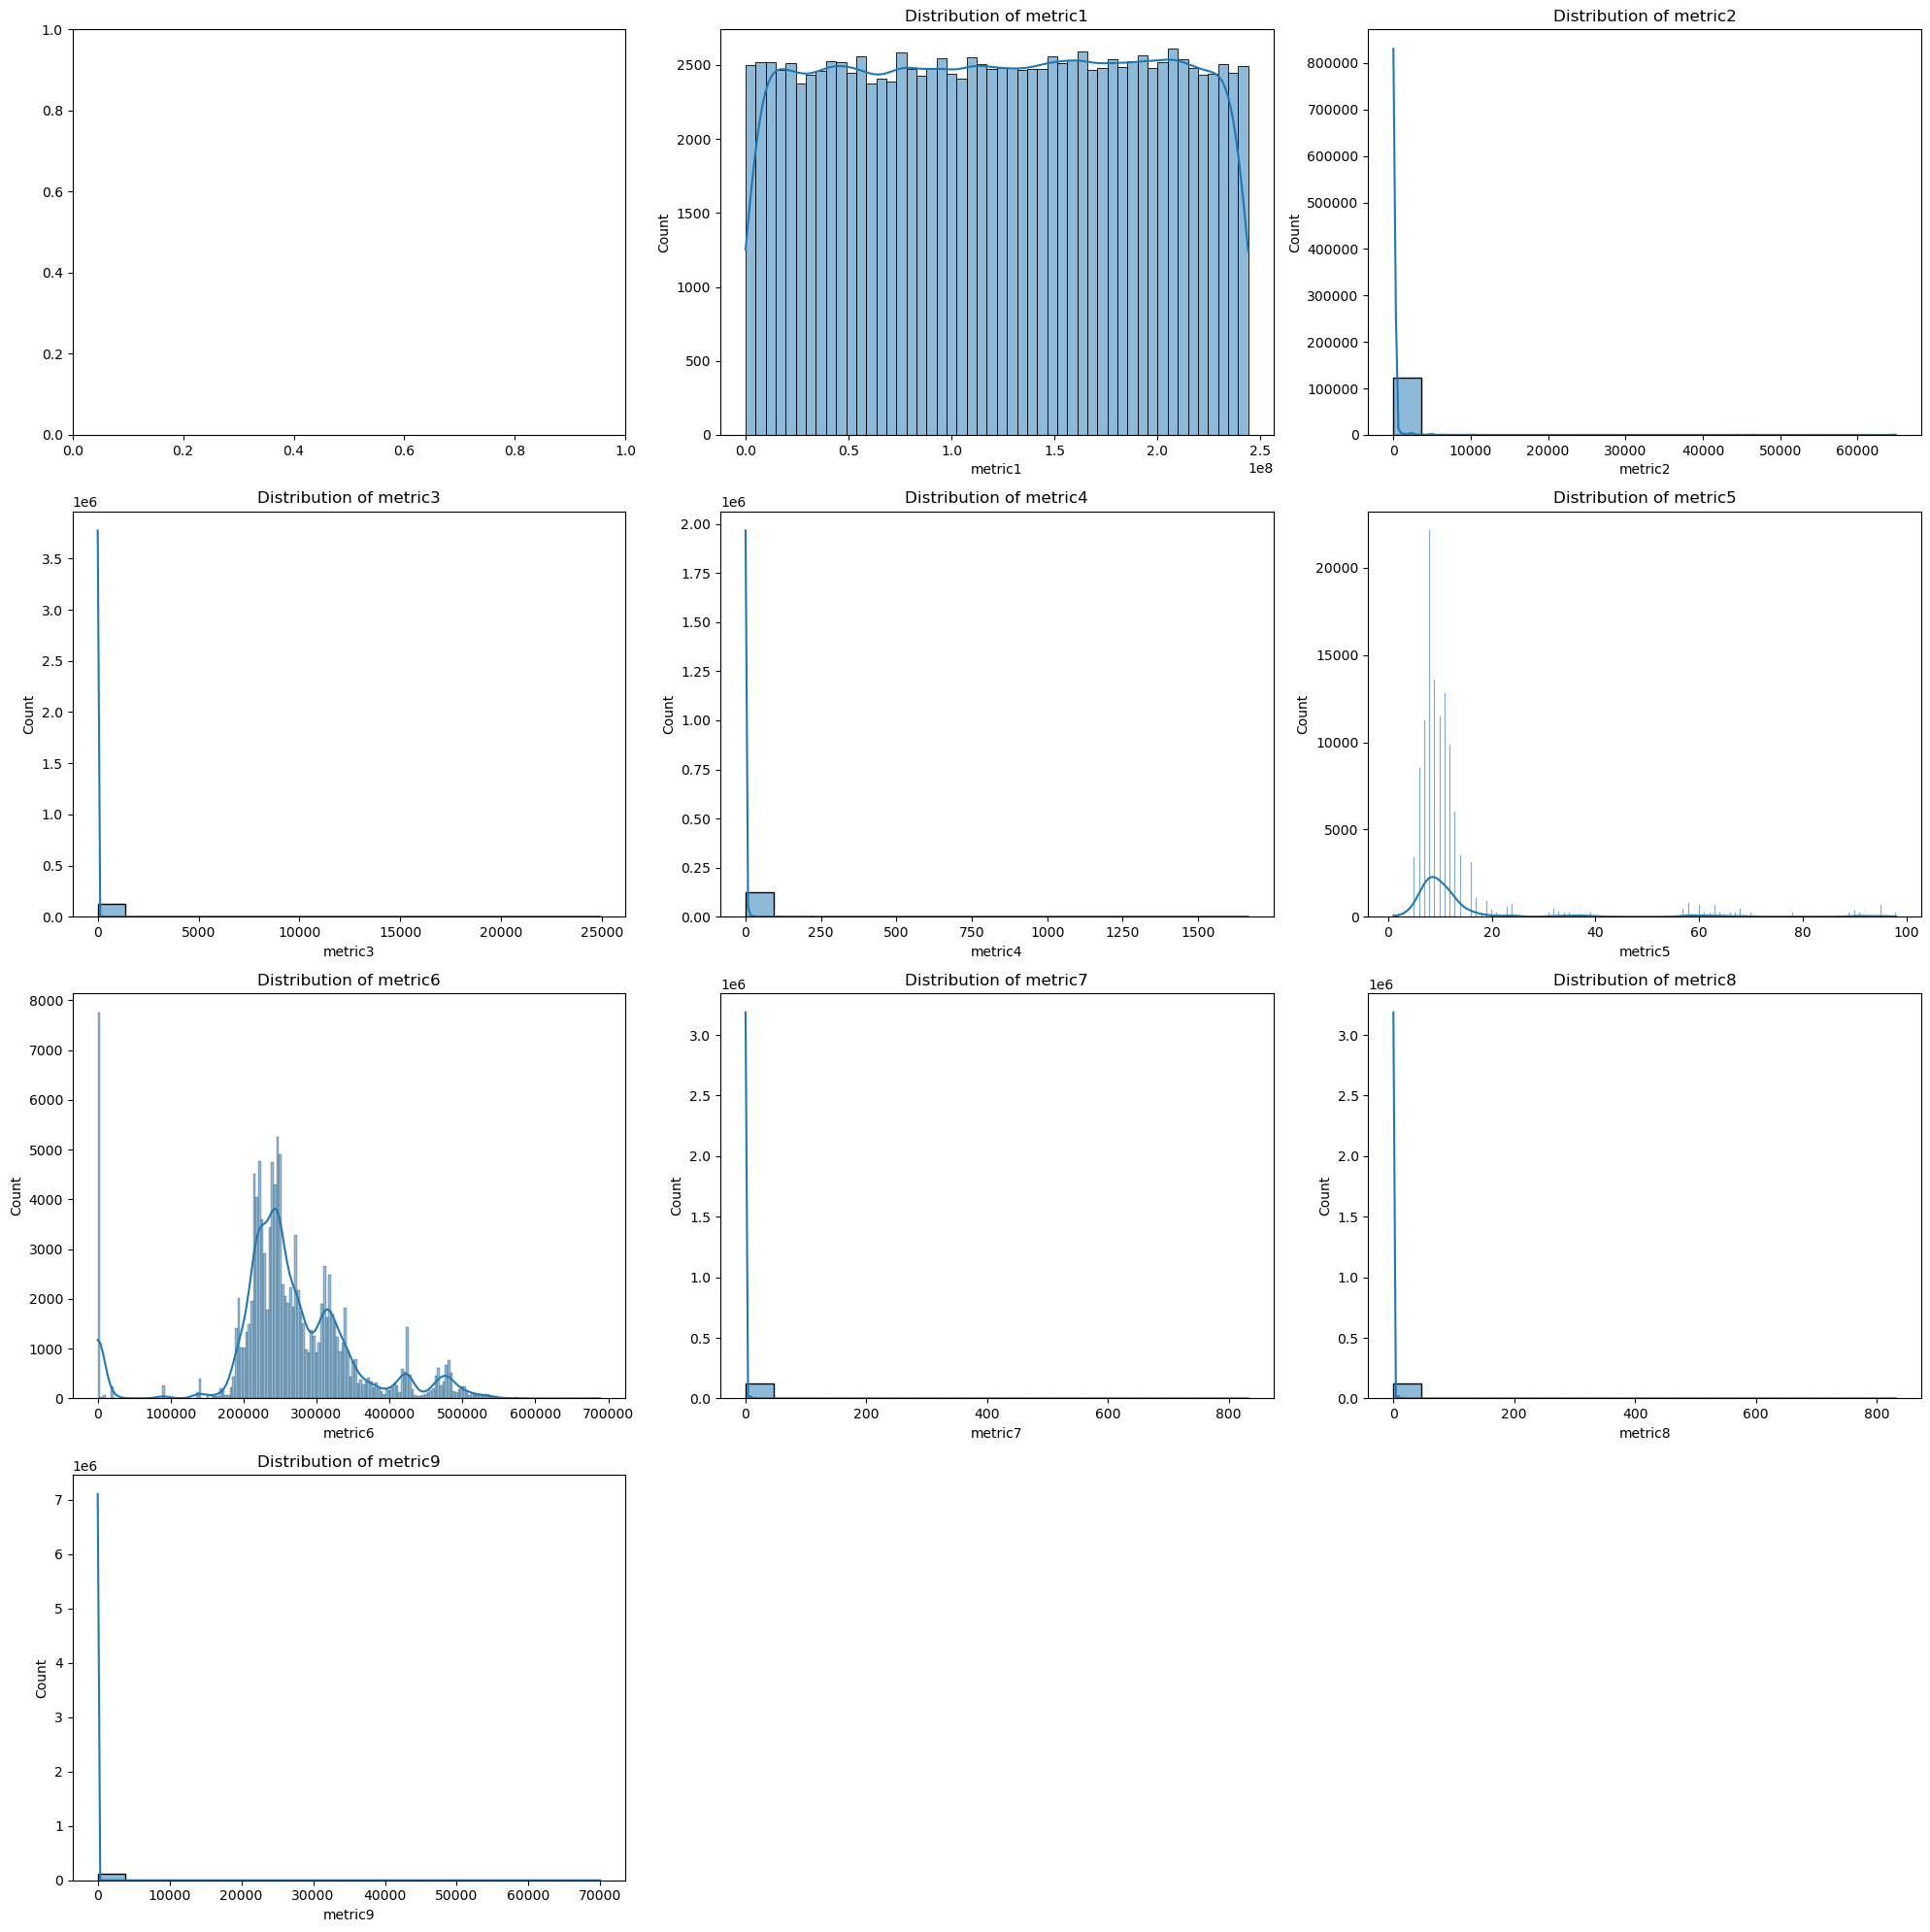

In [11]:
# Plot distribution of numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
num_features = len(numerical_features)
num_rows = (num_features - 1) // 3 + 1  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5*num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, feature in enumerate(numerical_features):
    if feature != 'failure':
        sns.histplot(data=df, x=feature, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
# Display unique values in 'device' column
print("\nUnique devices:")
print(df['device'].nunique())
print(df['device'].value_counts().head())

# Display date range
print("\nDate range:")
print(f"Start date: {df['date'].min()}")
print(f"End date: {df['date'].max()}")

# Display basic statistics for 'failure' column
print("\nFailure statistics:")
print(df['failure'].value_counts(normalize=True))


Unique devices:
1169
device
Z1F0QL3N    304
W1F0SJJ2    304
S1F0EGMT    304
S1F0FGBQ    304
S1F0FP0C    304
Name: count, dtype: int64

Date range:
Start date: 2015-01-01 00:00:00
End date: 2015-11-02 00:00:00

Failure statistics:
failure
0    0.999149
1    0.000851
Name: proportion, dtype: float64


## Feature Engineering

In [37]:
def clean_feature_eng(df):
    # Convert date to datetime if it's not already
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['device', 'date'])
    
    # handle highly skewed metrics (log transform)
    skewed_metrics = ['metric2', 'metric3', 'metric4', 'metric7', 'metric8', 'metric9']
    for metric in skewed_metrics:
        df[f'{metric}_log'] = np.log1p(df[metric])
    
    # create rolling aggregated features for each device
    rolling_window = 30  # 30-day 
    
    # calculate rolling mean
    def rolling_mean(group):
        return group.rolling(window=rolling_window, min_periods=1).mean()
    for metric in ['metric1', 'metric5', 'metric6']:
        df[f'rolling_mean_{metric}'] = df.groupby('device')[metric].transform(rolling_mean)
    
    # encode categorical variables (device id)
    device_encoded, device_mapping = pd.factorize(df['device'])
    df['device'] = device_encoded
    
    # create a reverse mapping (code to device name)
    device_reverse_mapping = dict(enumerate(device_mapping))
    
    # normalize numerical features, excluding 'failure' and time-based features
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cols_to_normalize = numeric_cols.drop(['failure', 'year', 'month', 'day', 'dayofweek', 'metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9'], errors='ignore')
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
    
    # Ensure 'failure' remains as binary (0 or 1)
    df['failure'] = df['failure'].astype(int)
    
    return df, cols_to_normalize, device_reverse_mapping

In [17]:
df_engineered, cols_normalized, device_mapping = clean_feature_eng(df)
print(df_engineered.info())
print("\nMissing values:")
print(df_engineered.isnull().sum())
print("\nFirst few rows:")
print(df_engineered.head())

<class 'pandas.core.frame.DataFrame'>
Index: 124494 entries, 0 to 67274
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  124494 non-null  datetime64[ns]
 1   device                124494 non-null  float64       
 2   failure               124494 non-null  int64         
 3   metric1               124494 non-null  int64         
 4   metric2               124494 non-null  int64         
 5   metric3               124494 non-null  int64         
 6   metric4               124494 non-null  int64         
 7   metric5               124494 non-null  int64         
 8   metric6               124494 non-null  int64         
 9   metric7               124494 non-null  int64         
 10  metric8               124494 non-null  int64         
 11  metric9               124494 non-null  int64         
 12  metric2_log           124494 non-null  float64       
 13  metri

In [18]:
# Convert date to Unix timestamp as float (fractional seconds)
df_engineered['EventTime'] = df_engineered['date'].astype(int) / 1e9

# Ensure EventTime is float64
df_engineered['EventTime'] = df_engineered['EventTime'].astype('float64')

# Create RecordId
df_engineered['RecordId'] = df_engineered.index.astype(str)

In [19]:
print("Available columns after feature engineering:")
print(df_engineered.columns)

device_columns = ['RecordId', 'EventTime', 'device', 'rolling_mean_metric1', 'rolling_mean_metric5', 'rolling_mean_metric6']
metrics_columns = ['RecordId', 'EventTime', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9',
                   'metric2_log', 'metric3_log', 'metric4_log', 'metric7_log', 'metric8_log', 'metric9_log']

# split data into device features and metrics features
device_features = df_engineered[[col for col in device_columns if col in df_engineered.columns]].copy()
metrics_features = df_engineered[[col for col in metrics_columns if col in df_engineered.columns]].copy()

Available columns after feature engineering:
Index(['date', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric8', 'metric9', 'metric2_log',
       'metric3_log', 'metric4_log', 'metric7_log', 'metric8_log',
       'metric9_log', 'rolling_mean_metric1', 'rolling_mean_metric5',
       'rolling_mean_metric6', 'EventTime', 'RecordId'],
      dtype='object')


In [21]:
# Verify the results
print("Engineered data info:")
print(df_engineered.info())

print("\nDevice features info:")
print(device_features.info())

print("\nMetrics features info:")
print(metrics_features.info())

# duplicates check
print("\nChecking for duplicate RecordId in device_features:")
print(device_features['RecordId'].duplicated().sum())

print("\nChecking for duplicate RecordId in metrics_features:")
print(metrics_features['RecordId'].duplicated().sum())

# sample rows
print("\nSample rows of engineered data:")
print(df_engineered.head())

# nan values
print("\nNumber of NaN values in each column:")
print(df_engineered.isna().sum())

# range of values for normalized columns
print("\nRange of values for normalized columns:")
for col in cols_normalized:
    print(f"{col}: Min = {df_engineered[col].min():.2f}, Max = {df_engineered[col].max():.2f}")

Engineered data info:
<class 'pandas.core.frame.DataFrame'>
Index: 124494 entries, 0 to 67274
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  124494 non-null  datetime64[ns]
 1   device                124494 non-null  float64       
 2   failure               124494 non-null  int64         
 3   metric1               124494 non-null  int64         
 4   metric2               124494 non-null  int64         
 5   metric3               124494 non-null  int64         
 6   metric4               124494 non-null  int64         
 7   metric5               124494 non-null  int64         
 8   metric6               124494 non-null  int64         
 9   metric7               124494 non-null  int64         
 10  metric8               124494 non-null  int64         
 11  metric9               124494 non-null  int64         
 12  metric2_log           124494 non-null  flo

In [23]:
# feature groups
device_feature_group_name = "device-feature-group-" + strftime("%d-%H-%M-%S", gmtime())
metrics_feature_group_name = "metrics-feature-group-" + strftime("%d-%H-%M-%S", gmtime())

device_feature_group = FeatureGroup(name=device_feature_group_name, sagemaker_session=feature_store_session)
metrics_feature_group = FeatureGroup(name=metrics_feature_group_name, sagemaker_session=feature_store_session)

In [ ]:
# load feature definitions
device_feature_group.load_feature_definitions(data_frame=device_features)
metrics_feature_group.load_feature_definitions(data_frame=metrics_features)

In [25]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

In [26]:
# create the groups
role = sagemaker.get_execution_role()

device_feature_group.create(
    s3_uri=f"s3://{default_bucket}/{prefix}/device_features",
    record_identifier_name="RecordId",
    event_time_feature_name="EventTime",
    role_arn=role,
    enable_online_store=True
)

metrics_feature_group.create(
    s3_uri=f"s3://{default_bucket}/{prefix}/metrics_features",
    record_identifier_name="RecordId",
    event_time_feature_name="EventTime",
    role_arn=role,
    enable_online_store=True
)

# Wait for Feature Group creation to complete
wait_for_feature_group_creation_complete(device_feature_group)
wait_for_feature_group_creation_complete(metrics_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup device-feature-group-07-18-04-51 successfully created.
Waiting for Feature Group Creation
FeatureGroup metrics-feature-group-07-18-04-51 successfully created.


In [27]:
def check_data_before_ingestion(df, group_name):
    print(f"\nPre-ingestion check for {group_name}:")
    print(f"Shape: {df.shape}")
    print("\nColumn info:")
    print(df.info())
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nData types:")
    print(df.dtypes)
    
    if 'failure' in df.columns:
        print("\nFailure distribution:")
        print(df['failure'].value_counts(normalize=True))
        print(f"Total failures: {df['failure'].sum()}")
    
    print("\nSample data:")
    print(df.head())

    if df.isnull().any().any():
        raise ValueError(f"Null values found in {group_name} dataset!")
    
    if 'failure' in df.columns and df['failure'].dtype != 'int64':
        raise ValueError("'failure' column should be of type int64!")
    
    print(f"\nPre-ingestion check for {group_name} passed successfully!")

In [28]:
check_data_before_ingestion(device_features, "Device Features")
check_data_before_ingestion(metrics_features, "Metrics Features")


Pre-ingestion check for Device Features:
Shape: (124494, 6)

Column info:
<class 'pandas.core.frame.DataFrame'>
Index: 124494 entries, 0 to 67274
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   RecordId              124494 non-null  object 
 1   EventTime             124494 non-null  float64
 2   device                124494 non-null  float64
 3   rolling_mean_metric1  124494 non-null  float64
 4   rolling_mean_metric5  124494 non-null  float64
 5   rolling_mean_metric6  124494 non-null  float64
dtypes: float64(5), object(1)
memory usage: 6.6+ MB
None

Missing values:
RecordId                0
EventTime               0
device                  0
rolling_mean_metric1    0
rolling_mean_metric5    0
rolling_mean_metric6    0
dtype: int64

Data types:
RecordId                 object
EventTime               float64
device                  float64
rolling_mean_metric1    float64
rolling_mean_metric5 

### Takes about 20 mins. Can play around with batch size

In [ ]:
def batch_ingest(feature_group, data_frame, batch_size=2000):
   num_records = len(data_frame)
   for i in range(0, num_records, batch_size):
       batch = data_frame.iloc[i:i+batch_size]
       feature_group.ingest(data_frame=batch, max_workers=10, wait=True)
       print(f"Ingested {i+batch_size} records out of {num_records}")
       time.sleep(1)

batch_ingest(device_feature_group, device_features)
batch_ingest(metrics_feature_group, metrics_features)

In [ ]:
# check if proper
print("\nVerifying Device Feature Group:")
print(device_feature_group.describe())

print("\nVerifying Metrics Feature Group:")
print(metrics_feature_group.describe())

In [31]:
import boto3
import time
import pandas as pd
import io

def get_query_results(query_execution_id, sagemaker_session):
    athena_client = sagemaker_session.boto_session.client('athena')
    s3_client = sagemaker_session.boto_session.client('s3')
    while True:
        response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
        state = response['QueryExecution']['Status']['State']
        if state in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
            break
        time.sleep(5)

    if state == 'SUCCEEDED':
        s3_path = response['QueryExecution']['ResultConfiguration']['OutputLocation']
        bucket = s3_path.split('/')[2]
        key = '/'.join(s3_path.split('/')[3:])

        # Get the results file from S3
        obj = s3_client.get_object(Bucket=bucket, Key=key)
        results = pd.read_csv(io.BytesIO(obj['Body'].read()))
        return results
    else:
        raise Exception(f"Query failed with state: {state}")

def post_ingestion_check(feature_group, group_name, sagemaker_session):
    print(f"\nPost-ingestion check for {group_name}:")
    
    # output location for query results
    default_bucket = sagemaker_session.default_bucket()
    output_location = f"s3://{default_bucket}/athena_query_results/"
    
    # get the total number of records
    count_query = feature_group.athena_query()
    count_execution_id = count_query.run(
        query_string=f"SELECT COUNT(*) as count FROM {count_query.table_name}",
        output_location=output_location
    )
    count_result = get_query_results(count_execution_id, sagemaker_session)
    total_count = count_result.iloc[0]['count']
    print(f"Total records in feature group: {total_count}")
    
    # sample some records
    sample_query = feature_group.athena_query()
    sample_execution_id = sample_query.run(
        query_string=f"SELECT * FROM {sample_query.table_name} LIMIT 5",
        output_location=output_location
    )
    sample_result = get_query_results(sample_execution_id, sagemaker_session)
    print("\nSample records:")
    print(sample_result)
    
    # if it's the metrics feature group, check failure counts
    if any(fd.feature_name == 'failure' for fd in feature_group.feature_definitions):
        failure_query = feature_group.athena_query()
        failure_execution_id = failure_query.run(
            query_string=f"SELECT SUM(failure) as total_failures FROM {failure_query.table_name}",
            output_location=output_location
        )
        failure_result = get_query_results(failure_execution_id, sagemaker_session)
        total_failures = failure_result.iloc[0]['total_failures']
        print(f"\nTotal failures in feature group: {total_failures}")
        
        failure_rate = total_failures / total_count
        print(f"Failure rate: {failure_rate:.6f}")

post_ingestion_check(device_feature_group, "Device Features", feature_store_session)
post_ingestion_check(metrics_feature_group, "Metrics Features", feature_store_session)


Post-ingestion check for Device Features:
Total records in feature group: 124494

Sample records:
   recordid     eventtime    device  rolling_mean_metric1  \
0      9052  1.420762e+09  1.080826             -0.710791   
1       853  1.420070e+09  0.720164             -0.667915   
2      9058  1.420762e+09  1.114447              1.135722   
3      9146  1.420762e+09  1.517899              0.411839   
4       922  1.420070e+09  0.934116             -0.791567   

   rolling_mean_metric5  rolling_mean_metric6               write_time  \
0             -0.512701             -0.554064  2024-10-07 18:16:37.779   
1             -0.387258              0.061403  2024-10-07 18:16:37.611   
2              2.874270             -0.342584  2024-10-07 18:16:37.779   
3             -0.387258             -0.618674  2024-10-07 18:16:37.779   
4             -0.199093             -0.568666  2024-10-07 18:16:37.611   

       api_invocation_time  is_deleted  
0  2024-10-07 18:13:27.000       False  
1  2024

In [ ]:
def get_original_device(encoded_value):
    return device_mapping[encoded_value]

# To decode the entire 'device' column back to original IDs
df_engineered['original_device'] = df_engineered['device'].map(device_mapping)

# Display a few rows to verify
print(df_engineered[['device', 'original_device']].head(10))

#print("\nAll device mappings:")
#for encoded, original in device_mapping.items():
    #print(f"Encoded: {encoded}, Original: {original}")

# To find the encoding for a specific device ID
def find_encoding_for_device(device_id):
    for encoded, original in device_mapping.items():
        if original == device_id:
            return encoded
    return None  # If not found

# Example usage
print(f"\nEncoding for 'S1F01085': {find_encoding_for_device('S1F01085')}")

# To get a list of all unique devices in your dataset
unique_devices = df_engineered['original_device'].unique()
print(f"\nNumber of unique devices: {len(unique_devices)}")
print("Sample of unique devices:")
print(unique_devices[:10])  # Print first 10 unique devices

In [22]:
def delete_feature_group(feature_group_name):
    try:
        response = sagemaker_client.delete_feature_group(
            FeatureGroupName=feature_group_name
        )
        print(f"Feature group '{feature_group_name}' has been deleted.")
    except Exception as e:
        print(f"Error deleting feature group '{feature_group_name}': {e}")

# Names of the feature groups to delete
feature_groups = [
    "device-feature-group-05-08-00-45",
    "metrics-feature-group-05-08-00-45"
]

# Delete each feature group
for fg in feature_groups:
    delete_feature_group(fg)

Feature group 'device-feature-group-05-08-00-45' has been deleted.
Feature group 'metrics-feature-group-05-08-00-45' has been deleted.


In [62]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>